ここではtrainの170000~190000で学習、予測した  
testは後半400のもので学習データのみシャッフル

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
from scipy.stats import mode

# 以下は訓練とテストデータが異なるファイルのとき

In [70]:
fold = "../train_random_range0to170000/"
# .npyファイルからデータをロード
train_x = np.load(f'{fold}x.npy')
train_y = np.load(f"{fold}label.npy")

# データの形状を表示
print("Shape of the loaded x data:", train_x.shape)
print("Shape of the loaded label data:", train_y.shape)

Shape of the loaded x data: (20000, 500)
Shape of the loaded label data: (20000,)


In [71]:
fold = "../train_170000to190000/"
# .npyファイルからデータをロード
test_x = np.load(f'{fold}x.npy')
test_y = np.load(f"{fold}label.npy")

# データの形状を表示
print("Shape of the loaded x data:", test_x.shape)
print("Shape of the loaded label data:", test_y.shape)

Shape of the loaded x data: (20000, 500)
Shape of the loaded label data: (20000,)


In [72]:
print(pd.Series(train_y).value_counts())
print(pd.Series(test_y).value_counts())

7.0    3261
5.0    3009
6.0    2985
8.0    2578
2.0    2503
1.0    2453
4.0    2352
3.0     859
Name: count, dtype: int64
7.0    3612
1.0    3315
4.0    2766
6.0    2637
2.0    2489
5.0    2419
8.0    1818
3.0     944
Name: count, dtype: int64


# 以下は訓練とテストが同じデータセットのとき

In [66]:
fold = "../train_170000to190000/"
# .npyファイルからデータをロード
x = np.load(f'{fold}x.npy')
label = np.load(f"{fold}label.npy")

# データの形状を表示
print("Shape of the loaded x data:", x.shape)
print("Shape of the loaded label data:", label.shape)

Shape of the loaded x data: (20000, 500)
Shape of the loaded label data: (20000,)


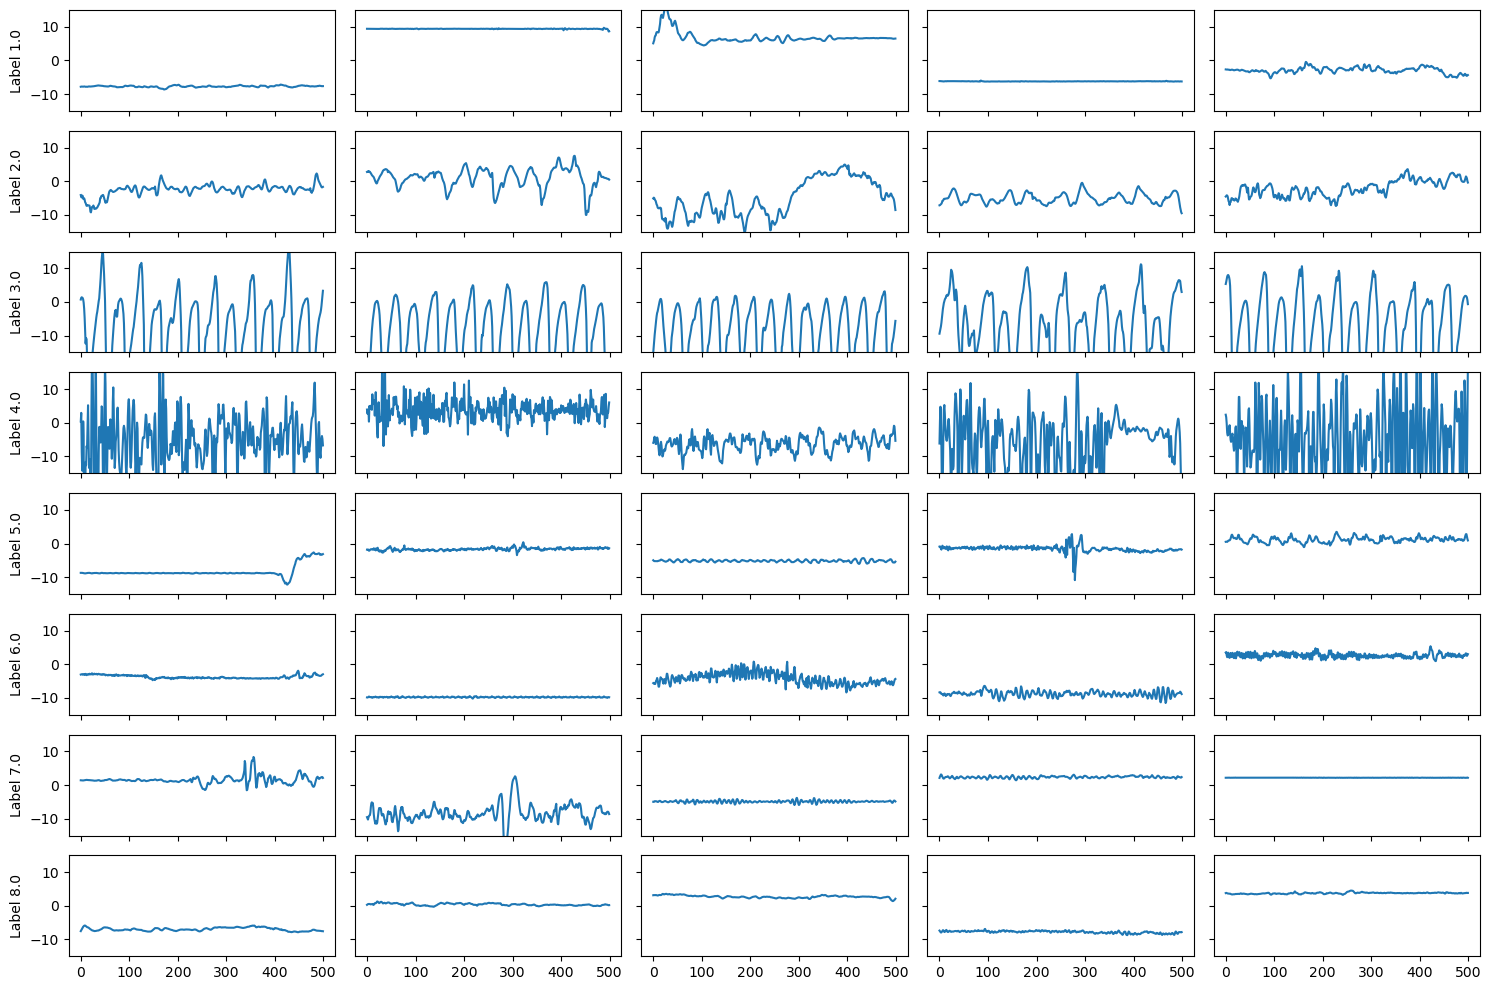

In [58]:
# 一意なラベルを取得
unqY = np.unique(label)

# 各アノテーションについて5つのグラフを描画
NPLOTS = 5
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(15, 10))

# 各ラベルについてのプロット
for y, row in zip(unqY, axs):
    indices = np.where(label
 == y)[0]
    
    # サンプリングインデックス数がNPLOTS未満の場合の対応
    if len(indices) < NPLOTS:
        sampled_indices = indices
    else:
        sampled_indices = np.random.choice(indices, size=NPLOTS, replace=False)
    
    row[0].set_ylabel(f'Label {y}')
    for x_data, ax in zip(x[sampled_indices], row):
        ax.plot(x_data)
        ax.set_ylim(-15, 15)

fig.tight_layout()
plt.show()


# train/test split

In [67]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, label, train_size=16000, shuffle=False)

In [73]:
# 分割後のデータの形状を表示
print("Shape of train_x:", train_x.shape)
print("Shape of test_x:", test_x.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_x: (20000, 500)
Shape of test_x: (20000, 500)
Shape of train_y: (20000,)
Shape of test_y: (20000,)


In [74]:
print(np.unique(train_y))
print(np.unique(test_y))

[1. 2. 3. 4. 5. 6. 7. 8.]
[1. 2. 3. 4. 5. 6. 7. 8.]


# 次元削減 t-SNE  

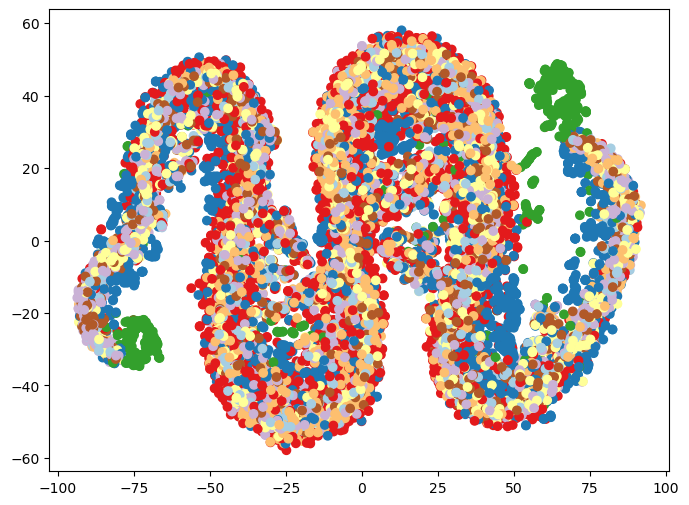

In [45]:
def plot_tsne(x, y, colormap=plt.cm.Paired):
    '''Visualize features with t-SNE'''
    plt.figure(figsize=(8, 6))
 
    # clean the figure
    plt.clf()
 
    tsne = manifold.TSNE()
    x_embedded = tsne.fit_transform(x)
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y, cmap=colormap)
 
    # plt.xticks(())
    # plt.yticks(())
    plt.show()
    return x_embedded[:,0], x_embedded[:,1]
 
# Visualize features
train_x_emb, train_y_emb = plot_tsne(train_x, train_y)

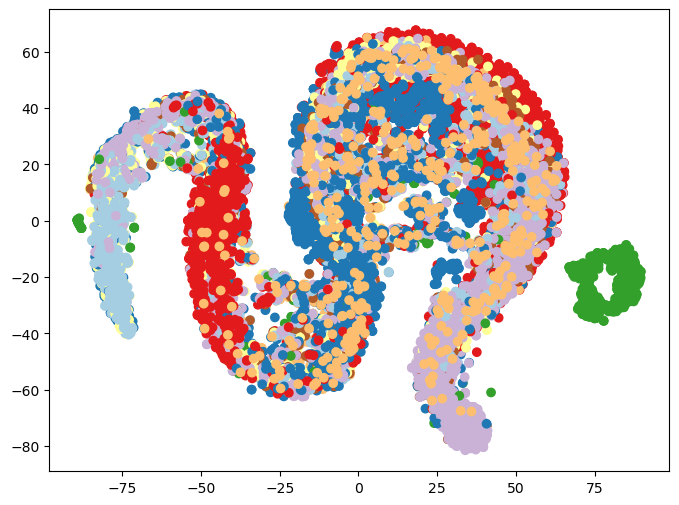

In [46]:

 
# Visualize features
test_x_emb, test_y_emb = plot_tsne(test_x, test_y)

In [51]:
train_x_embed = np.column_stack((train_x_emb, train_y_emb))
test_x_embed = np.column_stack((test_x_emb, test_y_emb))

train_x_embed, train_y  
test_x_embed, test_y

# 学習

In [75]:
"""indices = np.random.choice(train_x.shape[0], 16000, replace=False)
sampled_x_random = train_x[indices]
sampled_label_random = train_y[indices]
"""
clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=8,
    random_state=42,
    verbose=1
)
clf.fit(train_x, train_y)
#clf.fit(sampled_x_random,sampled_label_random) # 訓練データを使ってまずランダムフォレストを学習している。

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   40.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:  3.3min finished


BalancedRandomForestClassifier(n_estimators=2000, n_jobs=8, oob_score=True,
                               random_state=42, replacement=True,
                               sampling_strategy='not minority', verbose=1)

In [76]:
Y_test_pred = clf.predict(test_x) # 学習器の性能をみる テストデータで
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred, zero_division=0))
"""
# This will be the training set
Y_in_train = clf.oob_decision_function_.astype('float32') # OOBデータを用いて予測。結果をY_in_trainに入れている。
# This will be the test set
Y_in_test = clf.predict_proba(X_test).astype('float32') # クラス所属確率の予測も入っている。Y_test_predとは違って他のクラスへの所属確率も出力している点に留意"""

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    8.0s



Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.32      0.26      0.28      3315
         2.0       0.46      0.69      0.55      2489
         3.0       0.61      0.98      0.75       944
         4.0       0.64      0.41      0.50      2766
         5.0       0.33      0.34      0.33      2419
         6.0       0.31      0.40      0.35      2637
         7.0       0.33      0.26      0.29      3612
         8.0       0.14      0.12      0.13      1818

    accuracy                           0.38     20000
   macro avg       0.39      0.43      0.40     20000
weighted avg       0.38      0.38      0.37     20000



[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    8.9s finished


"\n# This will be the training set\nY_in_train = clf.oob_decision_function_.astype('float32') # OOBデータを用いて予測。結果をY_in_trainに入れている。\n# This will be the test set\nY_in_test = clf.predict_proba(X_test).astype('float32') # クラス所属確率の予測も入っている。Y_test_predとは違って他のクラスへの所属確率も出力している点に留意"